<a href="https://colab.research.google.com/github/DavianYang/lulc/blob/main/Landuse_and_Landcover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davian-yang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm
from glob import glob

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import wandb

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils.data import Subset, DataLoader, Dataset
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

if str(device) == "cuda:0":
    print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2025-02-02 20:57:18--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  16.1MB/s    in 6.5s    

2025-02-02 20:57:25 (13.8 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



# Data Exploration

In [6]:
data_dir = './EuroSAT/2750'

classes = os.listdir(data_dir)
print("Classes:", classes)

class_count = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
df = pd.DataFrame(list(class_count.items()), columns=['Class', 'Count'])
print("Data Distribution")
df

Classes: ['Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'Highway', 'HerbaceousVegetation', 'Forest', 'SeaLake', 'River', 'AnnualCrop']
Data Distribution


,Class,Count
0,Pasture,2000
1,Industrial,2500
2,Residential,3000
3,PermanentCrop,2500
4,Highway,2500
5,HerbaceousVegetation,3000
6,Forest,3000
7,SeaLake,3000
8,River,2500
9,AnnualCrop,3000


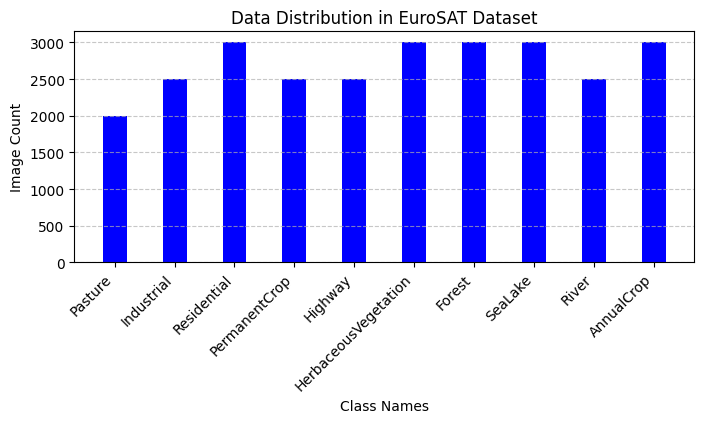

In [7]:
plt.figure(figsize=(8, 3))
plt.bar(df['Class'], df['Count'], color='blue', width=0.4)

plt.xlabel("Class Names")
plt.ylabel("Image Count")
plt.title("Data Distribution in EuroSAT Dataset")
plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Image Inspection

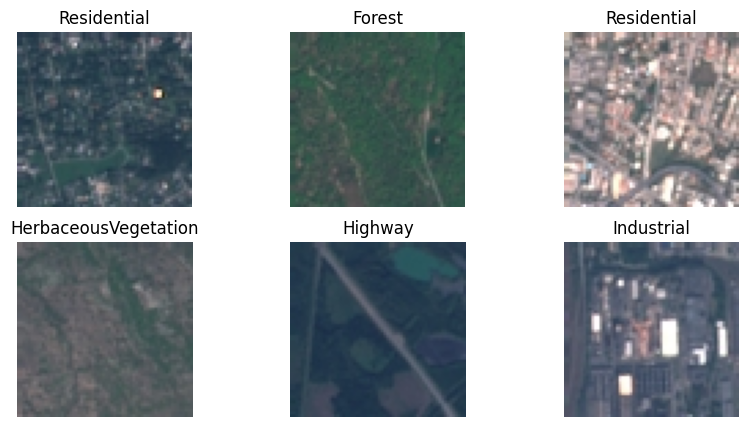

In [8]:
image_paths = glob(f"{data_dir}/*/*.jpg")
plt.figure(figsize=(10, 5))

for i, img_path in enumerate(np.random.choice(image_paths, 6, replace=False)):
  img = cv2.imread(img_path)[:, :, ::-1] # Convert BGR to RGB
  plt.subplot(2, 3, i+1)
  plt.imshow(img)
  plt.axis("off")
  plt.title(img_path.split('/')[-2])

plt.show()

All images have the same size: (64, 64)


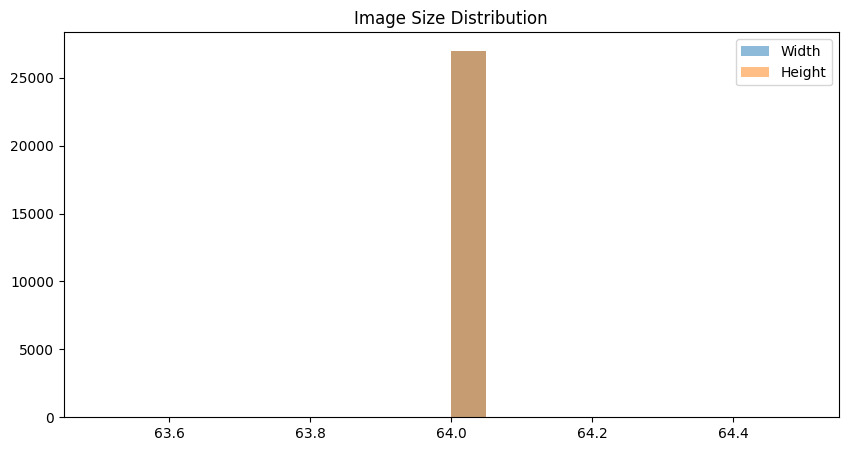

In [9]:
sizes = [Image.open(img_path).size for img_path in image_paths]
widths, heights = zip(*sizes)

unique_sizes = set(sizes)

if len(unique_sizes) == 1:
    print(f"All images have the same size: {unique_sizes.pop()}")
else:
    print(f"Different image sizes found: {unique_sizes}")


plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.legend()
plt.title("Image Size Distribution")
plt.show()

In [10]:
class EuroSAT(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    img, label = self.dataset[index]
    if self.transform:
      img = self.transform(img)

    return img, label

  def __len__(self):
    return len(self.dataset)

In [11]:
# Since we gonna use pretrained imagenet, so the input dataset is normalized to have the same statistics
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

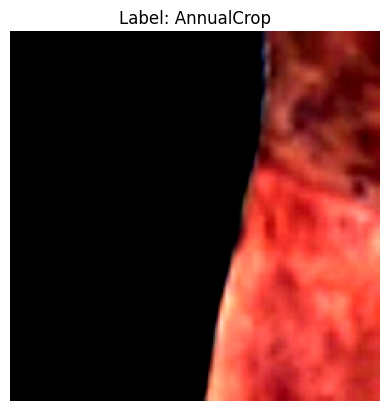

In [12]:
dataset = datasets.ImageFolder(data_dir, test_transform)

img, label = dataset[1]

img = img.permute(1, 2, 0).numpy() # (C, H, W) -> (H, W, C)
img = img.clip(0, 1) # ensure pixel values are in the range(0, 1)

plt.imshow(img)
plt.title(f"Label: {dataset.classes[label]}")
plt.axis('off')
plt.show()

In [13]:
train_size = 0.7
val_size = 0.15
test_size = 1.0 - train_size - val_size

indices = np.random.permutation(len(dataset))

train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))

train_indices = indices[:train_split]
val_indices = indices[train_split: train_split + val_split]
test_indices = indices[train_split + val_split:]

train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

print(f"Train/val/test size: {len(train_data)}/{len(val_data)}/{len(test_data)}")

Train/val/test size: 18900/4050/4050


In [14]:
num_workers = 2
batch_size = 16

train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True,
)

val_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

test_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

In [15]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
n_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [17]:
wandb.init(
    # set the wandb project where this run will be logged
    project="lulc",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "ResNet",
    "dataset": "EuroSAT",
    "epochs": n_epochs,
    }
)

wandb: Currently logged in as: davian-yang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [18]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")
  wandb.log({"Train Loss": epoch_loss, "Accuracy": epoch_accuracy})

  return epoch_loss, epoch_accuracy

In [19]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")
  wandb.log({"Loss": epoch_loss, "Accuracy": epoch_accuracy})

  return epoch_loss, epoch_accuracy

In [20]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Keep track of the best loss and
  # best model weights with the lowest loss
  best_loss = np.inf
  best_model = None

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

In [21]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.57; Accuracy: 58.25


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.87; Accuracy: 81.01
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.71; Accuracy: 80.25


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.41; Accuracy: 90.15
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.44; Accuracy: 86.85


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.29; Accuracy: 92.49
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.32; Accuracy: 90.20


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.17; Accuracy: 95.41
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.26; Accuracy: 91.92


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.14; Accuracy: 96.17
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.23; Accuracy: 92.98


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.15; Accuracy: 95.75
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.20; Accuracy: 93.57


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.11; Accuracy: 96.67
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.18; Accuracy: 94.31


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.10; Accuracy: 97.01
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.16; Accuracy: 94.84


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.09; Accuracy: 97.11
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.15; Accuracy: 95.32


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.12; Accuracy: 96.17


In [22]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")
wandb.finish()

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.12; Accuracy: 96.17


Accuracy,▁▅▅▇▆▇▇█▇█▇█▇█▇██████
Loss,█▄▃▂▁▂▁▁▁▁▁
Train Loss,█▄▂▂▂▁▁▁▁▁
Accuracy,96.17284
Loss,0.11576
Train Loss,0.14802


In [ ]:
model_dir = './drive/My Drive/Colab Notebooks/Landuse and Landcover Classifiation/models'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

In [24]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print(f'Model successfully saved to {model_file}')

In [25]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/Landuse and Landcover Classifiation/models/best_model.pth
